# Galactic trajectories
The following codes performs a backtracking simulation in the JF2012 galactic magnetic field model and visualizes the trajectories.
A custom simulation module is used for a numbered trajectory output, that simplifies separating the individual trajectories for plotting later on.

In [1]:
from crpropa import *

# magnetic field setup
B = JF12Field()
randomSeed = 691342
B.randomStriated(randomSeed)
B.randomTurbulent(randomSeed)

# simulation setup
sim = ModuleList()
sim.add(PropagationCK(B, 1e-4, 0.1 * parsec, 100 * parsec))
sim.add(SphericalBoundary(Vector3d(0), 20 * kpc))

class MyTrajectoryOutput(Module):
    """
    Custom trajectory output: i, x, y, z
    where i is a running cosmic ray number
    and x,y,z are the galactocentric coordinates in [kpc].
    """
    def __init__(self, fname):
        Module.__init__(self)
        self.fout = open(fname, 'w')
        self.fout.write('#i\tX\tY\tZ\n')
        self.i = 0
    def process(self, c):
        v = c.current.getPosition()
        x = v.x / kpc
        y = v.y / kpc
        z = v.z / kpc
        self.fout.write('%i\t%.3f\t%.3f\t%.3f\n'%(self.i, x, y, z))
        if not(c.isActive()):
            self.i += 1       
    def close(self):
        self.fout.close()
    

output = MyTrajectoryOutput('galactic_trajectories.txt')
sim.add(output)

# source setup
source = Source()
source.add(SourcePosition(Vector3d(-8.5, 0, 0) * kpc))
source.add(SourceIsotropicEmission())
source.add(SourceParticleType(-nucleusId(1,1)))
source.add(SourceEnergy(1 * EeV))

sim.run(source, 10)  # backtrack 10 random cosmic rays
output.close() # flush particles to ouput file

## 3D trajectory plot

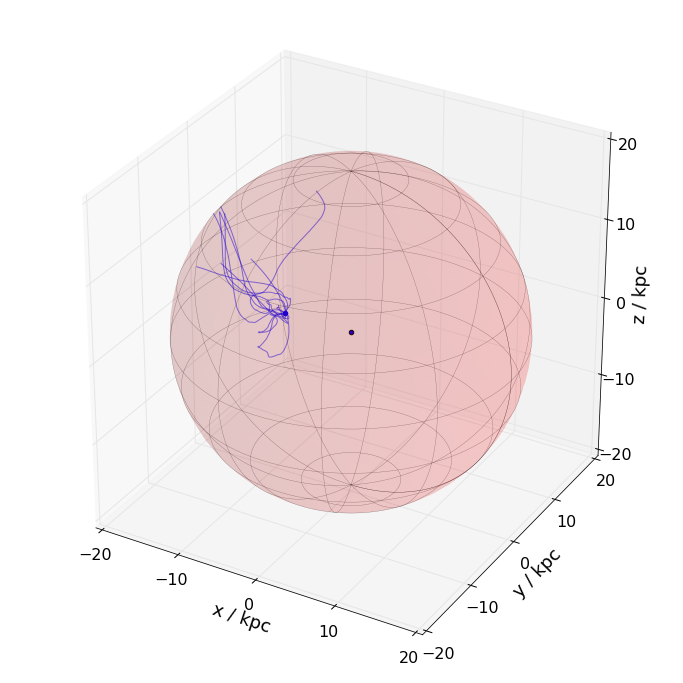

In [5]:
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
import  numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
ax = plt.subplot(111, projection='3d', aspect='equal')

# plot trajectories
I,X,Y,Z = np.genfromtxt('galactic_trajectories.txt', unpack=True, skip_footer=1)
for i in range(int(max(I))):
    idx = I == i
    ax.plot(X[idx], Y[idx], Z[idx], c='b', lw=1, alpha=0.5)

# plot galactic border
r = 20
u, v = np.meshgrid(np.linspace(0, 2*np.pi, 100), np.linspace(0, np.pi, 100))
x = r * np.cos(u) * np.sin(v)
y = r * np.sin(u) * np.sin(v)
z = r * np.cos(v)
ax.plot_surface(x, y, z, rstride=2, cstride=2, color='r', alpha=0.1, lw=0)
ax.plot_wireframe(x, y, z, rstride=10, cstride=10, color='k', alpha=0.5, lw=0.3)

# plot galactic center
ax.scatter(0,0,0, marker='o', color='k')
# plot earth
ax.scatter(-8.5,0,0, marker='o', color='b')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.set_xlabel('x / kpc', fontsize=18)
ax.set_ylabel('y / kpc', fontsize=18)
ax.set_zlabel('z / kpc', fontsize=18)
ax.set_xlim((-20, 20))
ax.set_ylim((-20, 20))
ax.set_zlim((-20, 20))
ax.xaxis.set_ticks((-20,-10,0,10,20))
ax.yaxis.set_ticks((-20,-10,0,10,20))
ax.zaxis.set_ticks((-20,-10,0,10,20))
plt.show()